In [1]:
#import
import math as m
import random as ran
import numpy as np
from PIL import Image
N32 = 2**32 
#function
def conv_dec_2_32bin(dec):
    binary_str = bin(dec)[2:]
    padded_bin_32bit = binary_str.zfill(32)
    return padded_bin_32bit

def conv_dec_2_31bin(dec):
    binary_str = bin(dec)[2:]
    padded_bin_31bit = binary_str.zfill(31)
    return padded_bin_31bit

def conv_dec_2_45bin(dec):
    binary_str = bin(dec)[2:]
    padded_bin_45bit = binary_str.zfill(45)
    return padded_bin_45bit

def conv_dec_2_10bin(dec):
    binary_str = bin(dec)[2:]
    padded_bin_10bit = binary_str.zfill(10)
    return padded_bin_10bit

def conv_bin_2_dec(bin_str):
    dec = int(bin_str, 2)
    return dec

def generate_IV(IVP,IVS,IVL,IVT):
    return conv_dec_2_32bin(IVP) + conv_dec_2_32bin(IVS) +conv_dec_2_32bin(IVL) + conv_dec_2_32bin(IVT)


def generate_secret_K(XP0,XS0,XL0,XT0,Pp,Ps,Tr,Eij):
    return conv_dec_2_32bin(XP0) + conv_dec_2_32bin(XS0) +conv_dec_2_32bin(XL0) + conv_dec_2_32bin(XT0)+ conv_dec_2_32bin(Q0) +  conv_dec_2_31bin(Pp) + conv_dec_2_32bin(Ps) + conv_dec_2_10bin(Tr) +conv_dec_2_45bin(Eij) 

def generate_random_bits(length):
    random_bits = ''.join(ran.choice('01') for _ in range(length))
    return random_bits

def reshape_to_square_matrix(matrix_1d, rows, cols):
    if len(matrix_1d) != rows * cols:
        raise ValueError("Kích thước của ma trận một chiều không phù hợp với kích thước của ma trận vuông.")
    
    square_matrix = []
    index = 0
    for i in range(rows):
        row = []
        for j in range(cols):
            row.append(matrix_1d[index])
            index += 1
        square_matrix.append(row)
    
    return square_matrix

def flatten_matrix(square_matrix):
    flattened_matrix = []
    for row in square_matrix:
        flattened_matrix.extend(row)
    return flattened_matrix
#Coupling system

def matrix_multiply(matrix_A, matrix_B):
    result = []
    for i in range(len(matrix_A)):
        row_result = 0
        for j in range(len(matrix_B)):
            row_result += matrix_A[i][j] * matrix_B[j]
        result.append(row_result)
    for i in range(len(result)):
        result[i] %=N32
    return result

def parameter_M(e):
    E_str = conv_dec_2_45bin(e)
    E_arr = []
    for i in range(0,9):
        n = 5*i
        E_arr.append(conv_bin_2_dec(E_str[n:n+5]))
    return E_arr

#Chaomaps

def PWLCM(x,p):
    x%=N32
    if(0 <= x < p):
        return m.floor((N32 * x)/p)
    elif (p <= x <N32/2):
        return m.floor(N32*(x-p)/(N32/2-p))
    elif (N32/2 <= x < N32-p):
        return m.floor(N32*(N32-x-p)/(N32/2-p))
    elif(N32-p <= x < N32):
        return m.floor(N32*(N32-x)/p)

def SkewT(x,p):
    x%=N32
    if (0< x <p ):
        return m.floor(N32*x/p)
    elif ( p <  x <N32):
        return m.floor(N32*(N32-x)/(N32-p))
    else:
        return (N32 - 1)

def Logistic(x):
    x%=N32
    if ((x != (3/4 * N32)) and (x != N32/2)):
        return m.floor(x*(N32-x)/(N32/4))
    elif(x == (3/4 * N32)):
        return (3/4 * N32 - 1)
    elif(x == N32/2):
        return (N32-1)


def Cher_3D(x):
    x%=N32
    return m.floor(4* (4*((x-N32/2)**3)-3/4*N32*N32*(x-N32/2))/(N32**2)+ N32/2)

#Sbox

def sub_byte(byte,S_BOX):
    hex(byte)
    row = (byte & 0xF0) >> 4
    col = byte & 0x0F
    return S_BOX[row][col]

def inv_sub_byte(inv_byte,S_BOX):
    hex(inv_byte)
    row = (inv_byte & 0xF0) >> 4
    col = inv_byte & 0x0F
    return S_BOX[row][col]

# Confusion layer

def sub_block(block,S_BOX):
    block = np.array(block)
    row, col = block.shape
    for i in range(row):
        for j in range(col):
            block[i][j] = sub_byte(block[i][j],S_BOX)
    return block

def inv_sub_block(block,S_BOX):
    block = np.array(block)
    row, col = block.shape
    for i in range(row):
        for j in range(col):
            block[i][j] = inv_sub_byte(block[i][j],S_BOX)
    return block

# 2D_cat_map (Permutation)
            
def per_row(i,j,ud,rid,rjd):
    ud = conv_bin_2_dec(ud)
    rid = conv_bin_2_dec(rid)
    rjd = conv_bin_2_dec(rjd)
    Z1 = rid + rjd 
    return (i+ud*j+Z1)%32

def per_col(i,j,ud,vd,rjd):
    ud = conv_bin_2_dec(ud)
    vd = conv_bin_2_dec(vd)
    rjd = conv_bin_2_dec(rjd)
    Z2 = ud *vd +1
    Z3 = vd*i + rjd
    return (Z3+Z2*j)%32

def Per_2D_cat_map(block,Kd):
    for i in range (0,32):
        for j in range (0,32):
            row = per_row(i,j,Kd[0:5],Kd[10:15],Kd[15:20])
            col = per_col(i,j,Kd[0:5],Kd[5:10],Kd[15:20])
            temp = block[row][col]
            block[row][col] = block[i][j]
            block[i][j] =  temp
    return block  

def Reverse_2D_cat_map(block,Kd):
    for i in range (0,32):
        for j in range (0,32):
            row = per_row(31-i,31-j,Kd[0:5],Kd[10:15],Kd[15:20])
            col = per_col(31-i,31-j,Kd[0:5],Kd[5:10],Kd[15:20])
            temp = block[row][col]
            block[row][col] = block[31-i][31-j]
            block[31-i][31-j] =  temp
    return block 

#HAD and VAD

def Mod256(x):
    if x >= 0:
        return x%256
    else:
        while(x < 0):
            x +=256
        return (x+256)%256

def HAD(block):
    block = block.astype(int)
    for i in range(32):
        for j in range(32):
            if (0<=i<=31 and 0<j<=31):
                block[i][j] = (block[i][j]+block[i][j-1])%256
            elif (0<i<=31 and j==0):
                block[i][j] = (block[i][j]+block[i-1][31])%256
            elif (i==j==0):
                block[i][j] = (block[i][j]+block[31][31])%256
    block = block.astype(np.uint8)
    return block

def VAD(block):
    block = block.astype(int)
    for i in range(32):
        for j in range(32):
            if (0<i<=31 and 0<=j<=31):
                block[i][j] = (block[i][j]+block[i-1][j])%256
            elif (i==0 and 0<j<=31):
                block[i][j] = (block[i][j]+block[31][j-1])%256
            elif (i==j==0):
                block[i][j] = (block[i][j]+block[31][31])%256
    block = block.astype(np.uint8)

    return block

def InvHAD(block):
    block = block.astype(int)
    for i in range(32):
        for j in range(32):
            row= 31-i
            col= 31-j
            if (0<=row<=31 and 0<col<=31):
                block[row][col] = Mod256(block[row][col]-block[row][col-1])
            elif (0<row<=31 and col==0):
                block[row][col] = Mod256(block[row][col]-block[row-1][31])
            elif (row==col==0):
                block[row][col] = Mod256(block[row][col]-block[31][31])
    block = block.astype(np.uint8)
    return block

def InvVAD(block):
    block = block.astype(int)
    for i in range(32):
        for j in range(32):
            row= 31-i
            col= 31-j
            if (0<row<=31 and 0<=col<=31):
                block[row][col] = Mod256(block[row][col]-block[row-1][col])
            elif (row==0 and 0<col<=31):
                block[row][col] = Mod256(block[row][col]-block[31][col-1])
            elif (row==col==0):
                block[row][col] = Mod256(block[row][col]-block[31][31])
    block = block.astype(np.uint8)
    return block

# Diffusion Layer
def Encryption_Diffusion(block,Kd):
    block = Per_2D_cat_map(block,Kd)
    block = HAD(block)
    block = VAD(block)
    return block

def Decryption_Diffusion(block,Kd):
    block = InvVAD(block)
    block = InvHAD(block)
    block = Reverse_2D_cat_map(block,Kd)
    return block
    
#LFSR

class LFSR32:
    def __init__(self, seed, taps):
        self.state = seed
        self.taps = taps

    def next(self):
        feedback = 0
        for tap in self.taps:
            feedback ^= int(self.state[32-tap])
        self.state = str(feedback) + self.state[:-1]

        return feedback

    def output_bit(self):
        return self.state[-1]

    def get_state(self):
        return self.state




In [2]:
# Image processing 

def is_color_image(image_path):
    image = Image.open(image_path)
    image_mode = image.mode
    return image_mode == "RGB"

def convert_to_grayscale(image_path):
    image = Image.open(image_path)
    grayscale_image = image.convert("L")  
    return grayscale_image

def resize_image(image_path, output_size):
    image = Image.open(image_path)
    resized_image = image.resize(output_size)
    return resized_image

def grayscale_to_matrix(image_path):
    image = Image.open(image_path)
    grayscale_image = image.convert("L")  
    grayscale_array = np.array(grayscale_image)  
    return grayscale_array

def split_image_to_blocks(image_matrix, block_size=(32, 32)):
    height, width = image_matrix.shape

    num_blocks_height = height // block_size[0]
    num_blocks_width = width // block_size[1]

    blocks = []
    for i in range(num_blocks_height):
        for j in range(num_blocks_width):
            block = image_matrix[i * block_size[0]: (i + 1) * block_size[0],
                                 j * block_size[1]: (j + 1) * block_size[1]]
            blocks.append(block)
    return blocks

def combine_blocks_to_image(blocks, image_shape):
    image = np.zeros(image_shape, dtype=np.uint8)

    block_height, block_width = blocks[0].shape

    num_blocks_height = image_shape[0] // block_height
    num_blocks_width = image_shape[1] // block_width

    current_block = 0

    for i in range(num_blocks_height):
        for j in range(num_blocks_width):
            block = blocks[current_block]
            image[i * block_height: (i + 1) * block_height,
                  j * block_width: (j + 1) * block_width] = block
            current_block += 1

    return image

def find_image_size(image_path):
    image = Image.open(image_path)
    width, height = image.size
    return width, height

#RGB processing

def image_to_rgb_matrix(image_path):
    image = Image.open(image_path)

        # Chuyển đổi ảnh thành ma trận RGB
    image_rgb = image.convert('RGB')

        # Lấy dữ liệu từ ma trận RGB
    data = list(image_rgb.getdata())

    return data

def split_image_to_rgb_matrices(image_path):
    image = Image.open(image_path)

        # Chuyển đổi ảnh thành ma trận RGB
    image_rgb = image.convert('RGB')

        # Tách thành các kênh màu
    r, g, b = image_rgb.split()

    return r, g, b

def merge_to_rgb_image(red_matrix, green_matrix, blue_matrix):
    rgb_image = Image.merge('RGB', (red_matrix, green_matrix, blue_matrix))
    return rgb_image


In [3]:

'''-------------------------------------------------------- PRNG_CS-------------------------------------------------'''




#Initial Vector in IV
IVP = 3123
IVS = 6532
IVL = 5673
IVT = 2314

#Initial conditions and parameters
Q0 = 2149580803
XP0 = 331424
XS0 = 53244
XL0 = 43256
XT0 = 65357
Pp  = 43252
Ps  = 5325
Tr  = 937
Eij = 1184747410975
E_arr = parameter_M(Eij)
# print(E_arr)
M=[
    [N32-E_arr[0]-E_arr[1]-E_arr[2],E_arr[0],E_arr[1],E_arr[2]],
    [E_arr[3],N32-E_arr[3]-E_arr[4]-E_arr[5],E_arr[4],E_arr[5]],
    [E_arr[6],E_arr[7],N32-E_arr[6]-E_arr[7]-E_arr[8],E_arr[8]],
    [E_arr[0],E_arr[1],E_arr[2],N32-E_arr[0]-E_arr[1]-E_arr[2]]
]

#LFSR
seed = conv_dec_2_32bin(Q0)
taps = [1,2,22,32]
LFSR = LFSR32(seed,taps)
LFSR_int = conv_bin_2_dec(LFSR.get_state())

#other

XP_0 = IVP + XP0 
XS_0 = IVS + XS0  
XL_0 = IVL + XL0 
XT_0 = IVT + XT0 

M_input = [PWLCM(XP_0,Pp),SkewT(XS_0,Ps),Logistic(XL_0),Cher_3D(XT_0)^LFSR_int]


class PRNG_CS:
    def __init__(self,IV,K):
        self.IV = IV
        IVP = conv_bin_2_dec(self.IV[0:32])
        IVS = conv_bin_2_dec(self.IV[32:64])
        IVL = conv_bin_2_dec(self.IV[64:96])
        IVT = conv_bin_2_dec(self.IV[96:128])
        self.K = K
        XP0 = conv_bin_2_dec(self.K[0:32])
        XS0 = conv_bin_2_dec(self.K[32:64])
        XL0 = conv_bin_2_dec(self.K[64:96])
        XT0 = conv_bin_2_dec(self.K[96:128])
        Q0 = conv_bin_2_dec(self.K[128:160])
        Pp = conv_bin_2_dec(self.K[160:191])
        Ps = conv_bin_2_dec(self.K[191:223])
        Tr = conv_bin_2_dec(self.K[223:233])
        Eij = conv_bin_2_dec(self.K[233:278])
        self.E_arr = parameter_M(Eij)
        self.M=[
        [N32-self.E_arr[0]-self.E_arr[1]-self.E_arr[2],self.E_arr[0],self.E_arr[1],self.E_arr[2]],
        [self.E_arr[3],N32-self.E_arr[3]-self.E_arr[4]-self.E_arr[5],self.E_arr[4],self.E_arr[5]],
        [self.E_arr[6],self.E_arr[7],N32-self.E_arr[6]-self.E_arr[7]-self.E_arr[8],self.E_arr[8]],
        [self.E_arr[0],self.E_arr[1],self.E_arr[2],N32-self.E_arr[0]-self.E_arr[1]-self.E_arr[2]]
        ]

        XP_0 = IVP + XP0 
        XS_0 = IVS + XS0  
        XL_0 = IVL + XL0 
        XT_0 = IVT + XT0
        M_input = [PWLCM(XP_0,Pp),SkewT(XS_0,Ps),Logistic(XL_0),Cher_3D(XT_0)^conv_bin_2_dec(LFSR.get_state())]     
        M_output = matrix_multiply(M,M_input)
        self.XPC = M_output[0]
        self.XSC = M_output[1]
        self.XLC = M_output[2]
        self.XTIC = M_output[3]
        self.Xn = self.XPC^self.XSC^self.XLC^self.XTIC
        self.Kc = conv_dec_2_32bin(self.Xn)
        self.kd = conv_dec_2_32bin(self.Xn)[12:32]
        self.state = 1

    def next(self):
        XP = PWLCM(self.XPC,Pp)
        XS = SkewT(self.XSC,Ps)
        XL = Logistic(self.XLC)
        XT = Cher_3D(self.XTIC)
        LFSR.next()
        XTC = conv_bin_2_dec(LFSR.get_state())^XT
        M_input  = [XP,XS,XL,XTC]
        M_output = matrix_multiply(self.M,M_input)
        self.XPC = M_output[0]
        self.XSC = M_output[1]
        self.XLC = M_output[2]
        self.XTIC = M_output[3]
        self.Xn = (self.XPC ^  self.XSC ^self.XLC ^ self.XTIC)#%N32
        self.state += 1
        self.Kc += conv_dec_2_32bin(self.Xn)
        self.Kd = conv_dec_2_32bin(self.Xn)[12:32]
        return self.state
    
    def get_output(self):
        return conv_dec_2_32bin(self.Xn)
    
    def get_state(self):
        return self.state
    
    def get_int_out(self):
        return self.Xn
    
    def get_Kc(self):
        return self.Kc
    
    def get_Kd(self):
        i = 1
        while((conv_bin_2_dec(self.Kd[0:5]) == 0 or conv_bin_2_dec(self.Kd[5:10]) == 0 or conv_bin_2_dec(self.Kd[10:15]) == 0 or conv_bin_2_dec(self.Kd[15:20]) == 0) and (self.Kd != self.Kc[:20])):     
            self.Kd = self.Kc[-20-i:-i]
            i+=1
        return self.Kd
    
    def get_ud(self):
        return self.get_Kd()[0:5]
    
    def get_vd(self):
        return self.get_Kd()[5:10]
    
    def get_rid(self):
        return self.get_Kd()[10:15]
    
    def get_rjd(self):
        return self.get_Kd()[15:20]

#S_Box
    
def Generate_Sbox(prng_CS):
    sample = 0
    S = []
    while (sample <= 255):
        x = prng_CS.get_int_out() % 256
        if (x not in S):
            S.append(x)
            sample+=1
        prng_CS.next()
    Sb  = reshape_to_square_matrix(S,16,16)
    return Sb




In [4]:
#----------------------------------------------Main-------------------------------


prng_CS = PRNG_CS(generate_IV(IVP,IVS,IVL,IVT),generate_secret_K(XP0,XS0,XL0,XT0,Pp,Ps,Tr,Eij))

Sb =  Generate_Sbox(prng_CS)


#Encryption

def Encyption(input_image_path,output_image_path,S_Box,prng_CS,round):
    image_matrix = grayscale_to_matrix(input_image_path)
    blocks = split_image_to_blocks(image_matrix,block_size = (32,32))
    for c in range(round):
        for i in range(len(blocks)):
            blocks[i] = sub_block(blocks[i],S_Box)
            blocks[i] = Encryption_Diffusion(blocks[i],prng_CS.get_Kd())
        prng_CS.next()
    image = combine_blocks_to_image(blocks, image_matrix.shape)
    Image.fromarray(image).save(output_image_path)
    return image

def Encyption_RGB(input_image_path,output_image_path,S_Box,prng_CS,round):
    
    #Split image
    red_matrix, green_matrix, blue_matrix = split_image_to_rgb_matrices(input_image_path)
    #Split block
    r = np.array(red_matrix) 
    g = np.array(green_matrix) 
    b = np.array(blue_matrix) 
    red = split_image_to_blocks(r,block_size=(32, 32))
    green = split_image_to_blocks(g,block_size=(32, 32))
    blue = split_image_to_blocks(b,block_size=(32, 32))
    for c in range(round):
        for i in range(len(red)):
            red[i] = sub_block(red[i],S_Box)
            red[i] = Encryption_Diffusion(red[i],prng_CS.get_Kd())
        for i in range(len(green)):
            green[i] = sub_block(green[i],S_Box)
            green[i] = Encryption_Diffusion(green[i],prng_CS.get_Kd())
        for i in range(len(blue)):
            blue[i] = sub_block(blue[i],S_Box)
            blue[i] = Encryption_Diffusion(blue[i],prng_CS.get_Kd())
        prng_CS.next()

    r = combine_blocks_to_image(red,r.shape)
    g = combine_blocks_to_image(green,g.shape)
    b = combine_blocks_to_image(blue,b.shape)

    r =Image.fromarray(r, mode='L')
    g =Image.fromarray(g, mode='L')
    b =Image.fromarray(b, mode='L')

    rgb_image = merge_to_rgb_image(r, g, b)
    rgb_image = np.array(rgb_image,dtype=np.uint8)
    Image.fromarray(rgb_image).save(output_image_path)
    return rgb_image

# image_path = "plain_images/lenna512x512.png"
# output_path = "HAD_VAD\Testrgb.png"

image_path = "C:\DATN\plain_images\Black_512.png"
output_path = "HAD_VAD\Black_512.png"
if (is_color_image(image_path)):
    Encyption_RGB(image_path,output_path,Sb,prng_CS,1)
else: 
    Encyption(image_path,output_path,Sb,prng_CS,1)
print("Encrypt done")
print("Save in:", output_path)
print(Sb)
# Encyption(image_path,output_path,Sb,prng_CS,1)
# print("Encrypt done")
# print("Save in:", output_path)

Encrypt done
Save in: HAD_VAD\Black_512.png
[[80, 63, 59, 70, 201, 58, 142, 169, 154, 223, 232, 39, 220, 181, 125, 221], [38, 135, 126, 46, 113, 160, 109, 110, 177, 112, 189, 127, 128, 89, 29, 230], [168, 0, 75, 162, 141, 205, 22, 53, 105, 151, 219, 31, 79, 255, 64, 161], [65, 115, 93, 194, 245, 87, 251, 35, 111, 20, 216, 163, 34, 238, 252, 218], [225, 190, 118, 170, 186, 67, 179, 73, 134, 96, 172, 83, 61, 119, 158, 103], [86, 247, 94, 180, 130, 137, 122, 28, 173, 121, 187, 18, 150, 10, 102, 204], [97, 78, 57, 114, 42, 120, 30, 239, 234, 123, 16, 60, 159, 23, 76, 228], [206, 210, 246, 19, 149, 36, 145, 68, 250, 2, 253, 66, 249, 84, 226, 17], [81, 156, 74, 192, 144, 244, 104, 13, 131, 50, 240, 222, 215, 235, 124, 1], [203, 44, 193, 132, 69, 106, 200, 198, 21, 14, 140, 242, 166, 157, 9, 147], [143, 209, 41, 129, 117, 178, 241, 176, 43, 88, 233, 100, 6, 3, 243, 229], [116, 101, 152, 211, 213, 52, 248, 90, 98, 99, 54, 183, 202, 224, 236, 95], [77, 138, 185, 25, 47, 91, 184, 108, 191, 199, 

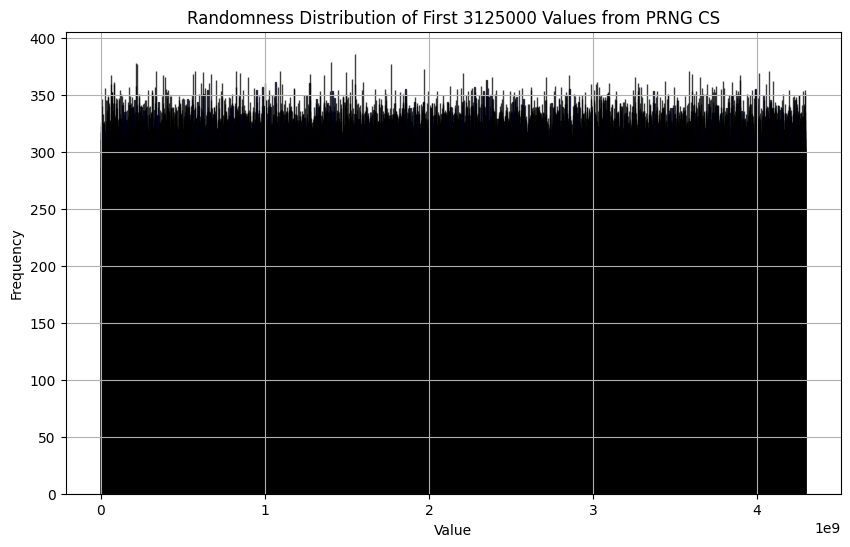

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Dummy class to simulate PRNG_CS
class PRNG_CS:
    def __init__(self, IV, K):
        self.state = int(K[:32], 2)
    
    def next(self):
        self.state = (self.state * 1103515245 + 12345) % (2**32)
    
    def get_int_out(self):
        return self.state

# Assuming the generate_IV and generate_secret_K functions are already defined
IVP = 3123
IVS = 6532
IVL = 5673
IVT = 2314

XP0 = 331424
XS0 = 53244
XL0 = 43256
XT0 = 65357
Q0 = 2149580803
Pp  = 43252
Ps  = 5325
Tr  = 937
Eij = 1184747410975

def conv_dec_2_32bin(x): return bin(x)[2:].zfill(32)
def generate_IV(IVP, IVS, IVL, IVT): return conv_dec_2_32bin(IVP) + conv_dec_2_32bin(IVS) + conv_dec_2_32bin(IVL) + conv_dec_2_32bin(IVT)
def generate_secret_K(XP0, XS0, XL0, XT0, Pp, Ps, Tr, Eij): return ''.join(map(conv_dec_2_32bin, [XP0, XS0, XL0, XT0, Q0, Pp, Ps, Tr, Eij]))

prng_CS = PRNG_CS(generate_IV(IVP, IVS, IVL, IVT), generate_secret_K(XP0, XS0, XL0, XT0, Pp, Ps, Tr, Eij))

# Generate 10000 values
values = [prng_CS.get_int_out()]
for _ in range(3125000):
    prng_CS.next()
    values.append(prng_CS.get_int_out())

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(values, bins=10000, alpha=0.75, color='blue', edgecolor='black')
plt.title('Randomness Distribution of First 3125000 Values from PRNG CS')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
